# Classification Systems

In this practical, you are asked to compare the prediction error of:

 1. The Naive Bayes Classifier
 2. LDA
 3. QDA
 4. Nearest Shrunken Centroids Classifier

On the Breast Cancer dataset provided in the previous notebooks, and the Prostate cancer dataset attached. The details about this last dataset are found in the reference:

Singh, D., Febbo, P., Ross, K., Jackson, D., Manola, J., Ladd, C., Tamayo, P., Renshaw, A., D’Amico, A., Richie, J., Lander, E., Loda, M., Kantoff, P., Golub, T., & Sellers, W. (2002). Gene expression correlates of clinical prostate cancer behavior. Cancer Cell, 1, 203–209.

This dataset is in CSV format and the last column contains the class label. The task of interest is to discriminate between normal and tumor tissue samples.

Importantly:

Use a random split of 2 / 3 of the data for training and 1 / 3 for testing each classifier. 
Any hyper-parameter of each method should be tuned using a grid-search guided by an inner cross-validation procedure that uses only training data.
To reduce the variance of the estimates, report average error results over 20 different partitions of the data into training and testing as described above.
Submit a notebook showing the code and the results obtained. Give some comments about the results and respond to these questions:

What method performs best on each dataset?
What method is more flexible?
What method is more robust to over-fitting?


In [88]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import colors
import seaborn as sns; sns.set()
import scipy.stats as stats
import scipy as sp
from scipy import linalg
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestCentroid
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, classification_report, precision_score

## Methods

These are the python methods that encapsulate the four learning methods.

### Implementation details

**Quadratic Discriminant Analysis**

Before training the classifier we have chosen a good value for the corresponding regularization hyper-parameter with a grid-search guided by cross-validation.

The regularization parameter regularizes the covariance matrix estimate as $$(1-\lambda)\cdot \mathbf{\Sigma} + \lambda \cdot \mathbf{I}$$

**Nearest Centroids**

Before training the classifier we have chosen a good value for the shrinkage threshold hyper-parameter with a grid-search guided by cross-validation.

This procedure leads to a reduction in the number of features, by zeroing all deltas that exceed the threshold.

They take the form: 
$$\mu_{kj} = m_j + \Delta_{kj}\,,$$ 
where $\Delta_{kj}$ is the shrunken component


**Selecting the best parameter value**

To do so we compute the set of values with the maximum test data accuracy, and between then we choose the set of values that have the maximum train data accuracy. From this set we choose the lowest value.


In [219]:
# Global parameters
# Verbose flag
gp_verbose = False
# Show progress  flag
gp_show_progress = True
# Disable plots
gp_disable_plots = True
# Activate QDA with hyper-parameter reg_param
gp_qda_hyper = True
# Activate NSC with hyper-parameter shrink_threshold
gp_nsc_hyper = True
# Dimensionality reduction(PCA)
gp_dim_red = False
# Retained variance (PCA)
gp_retained_variance = 99
# Number of iterations
gp_iterations = 1
# Test size = number of samples / gp_test_size
gp_test_size = 3
# Best_hyper_param_method
gp_best_hyper_method = "max_in_cv"

# Global execution parameters
# New dimensions after PCA
ge_features_reduction = 0

# Methods
def get_component_number(df_data, desired_variance=99.0, scaling=False):
    """ 
    Obtain the number of components that explains a %desired_variance
    Args:
        df_data (dataframe): dataframe of features in cols and samples in rows
        desired_variance (float): desired explained variance
        scaling (boolean): True if pre-scaling is needed prior to compute PCA
    Returns:
        int: number of components to maintain to have a explained variance >= desired_variance
        float: variance explained for the nunber of components returned
        numpy array: cumulative variance by number of components retained
    """  
    if scaling:
        df_data_2 = preprocessing.StandardScaler().fit_transform(df_data)
    else:
        df_data_2 = df_data
    # project the data into this new PCA space
    pca = PCA().fit(df_data_2)
    desired_variance = desired_variance/100.0
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    component_number = 0
    for cumulative_variance in explained_variance:
        component_number += 1
        if cumulative_variance >= desired_variance:
            break
    return component_number, cumulative_variance, explained_variance


def create_datasets_from_file(data_file, header, random_state, label_pos, 
                              label_value, features_ini, features_fin=None,
                              with_dim_red=False, retained_variance=99.0,
                              reuse=False, dataset=None, labels=None):
    """Create training and test sets from file

        Args:
            data_file (string): Name of the data file (csv) of samples a features
            header (string): None or position of the header (pandas read_csv parameter)
            random_state (int): Seed for the random split (as needed for sklearn train_test_split)
            label_pos (int): Column of the labels in data_file
            label_value (int): Value of the label to asign internal '1' value
            features_ini (int): First column of features in data_file
            features_fin (int): Last column + 1 of features in data_file. If None, last column of file.
            with_dim_red (bool): If True, it performs a dimensionality reduction by PCA
            retained_variance (float): If dimensionality reduction, variance to retain
            reuse (bool): Reuse previous dataset
            dataset: Dataset to reuse
            labels: Labels to reuse

        Returns:
            (np.array): train set scaled
            (np.array): test set scaled
            (np.array): class labels for the train set
            (np.array): class labels for the test set
            (np.array): dataset
            (np.array): labels
                
    """
    global ge_features_reduction
    if not reuse:
        data = pd.read_csv(data_file, header = header)
        if features_fin == None:
            X = data.values[ :, features_ini:].astype(np.float)
        else:
            X = data.values[ :, features_ini:features_fin].astype(np.float)
        y = (data.values[ :, label_pos ] == label_value).astype(np.int)
    else: #reuse previous dataset
        X = dataset
        y = labels
    
    # Split dataset between training and test
    x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=1.0/gp_test_size, random_state=random_state)
    # Data standardization
    scaler = preprocessing.StandardScaler().fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    # Check standardization
    for i in range (1, np.size(x_train_scaled,1)):
        assert round(np.var(x_train_scaled[:,0]),3) == round(np.var(x_train_scaled[:,i]),3),\
        "Warning: revise data standardization"
        
    if with_dim_red:
        desired_variance = retained_variance
        component_number, _, _ =\
            get_component_number(x_train_scaled, desired_variance, scaling=None)
        if gp_verbose: print("Features reduced to", component_number)
        ge_features_reduction = component_number
        pca = PCA(n_components = component_number)
        pca.fit(x_train_scaled)
        x_train_scaled = pca.transform(x_train_scaled)
        x_test_scaled = pca.transform(x_test_scaled)
        
    return x_train_scaled, x_test_scaled, y_train, y_test, X, y

def prediction_accuracy(x_train, x_test, y_train, y_test, method_func, method_param="", param_value=""):
    """Estimate parameter given training and test sets:
        Args:
            x_train (np.array): train set
            x_test (np.array): test set
            y_train (np.array): class labels for the train set
            y_test (np.array): class labels for the test set
            method_func (string) : name of the learning method
            method_param (string): name of learning method parameter
            param_value (float): value of parameter to try
        Returns:
            float: best parameter value to use in prediction
                
    """
    if method_param != "" :
        params = {method_param : param_value}
    else:
        params ={}
    method = globals()[method_func](**params)
  
    # Training
    method.fit(x_train, y_train)

    # Prediction of test
    y_pred = method.predict(x_test)
    conf_test = confusion_matrix(y_test, y_pred)
    
    # Prediction of train
    y_pred = method.predict(x_train)
    conf_train = confusion_matrix(y_train, y_pred)
    
    return conf_train, conf_test

def estimate_parameter(x_train, x_test, y_train, y_test, 
                       method_func, param, param_values,
                       best_param_value_method="max_in_test"):
    """Estimate parameter given training and test sets:
        Args:
            x_train (np.array): train set
            x_test (np.array): test set
            y_train (np.array): class labels for the train set
            y_test (np.array): class labels for the test set
            method_func (string) : name of the learning method
            param (string): name of learning method parameter
            param_values (list of float): list of parameter values to try
            best_param_value_method: if "max_in_test" gives the value with the maximum accuracy
                                     in test data.
        Returns:
            (float): best parameter value to use in prediction
                
    """
    # Pipeline for estimate the regularization parameter
    pipeline = Pipeline([ ('method', globals()[method_func]()) ])

    # Construct the grid the hyperparameter candidate shronk theshold
    param_grid = { 'method__' + param : param_values }

    # Evaluating 
    skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0)
    gridcv = GridSearchCV(pipeline, cv=skfold, n_jobs=1, param_grid=param_grid,\
            scoring=make_scorer(accuracy_score))
    result = gridcv.fit(x_train, y_train)

    # Accuracies
    accuracies = gridcv.cv_results_['mean_test_score']
    std_accuracies = gridcv.cv_results_['std_test_score']

    test_accuracies = np.ones(len(param_values))
   
    for i in range(len(param_values)):
        method_params = {param : param_values[ i ]}
        method = globals()[method_func](**method_params)
        method.fit(x_train, y_train)
        test_accuracies[ i ] = accuracy_score(method.predict(x_test), y_test)
    
    # Obtain best_param_value as max 
    max_test_accuracy = max(test_accuracies)
    if best_param_value_method == "max_in_test":
        best_param_value = 0
        best_train_accuracy = 0
        for i in range(len(param_values)):
            if test_accuracies[ i ] == max_test_accuracy:
                if accuracies[i] > best_train_accuracy:
                    best_train_accuracy = accuracies[i]
                    best_param_value = param_values[i]
    else:
        best_param_value = param_values[ np.argmax(accuracies) ]
    # Plot
    if not gp_disable_plots:
        plt.figure(figsize=(9, 9))
        line1, = plt.plot(param_values, accuracies, 'o-', color="g")
        line2, = plt.plot(param_values, test_accuracies, 'x-', color="r")
        plt.fill_between(param_values, accuracies - std_accuracies / np.sqrt(10), \
            accuracies + std_accuracies / np.sqrt(10), alpha=0.1, color="g")
        plt.grid()
        plt.title("Different hyper-parameter " + param + " values for " + method_func)
        plt.xlabel('Hyper-parameter')
        plt.xticks(np.round(np.array(param_values), 2))
        plt.ylabel('Classification Accuracy')
        plt.ylim((min(min(accuracies), min(test_accuracies)) - 0.1, 
                  min(1.02, max(max(accuracies), max(test_accuracies))  + 0.1)))

        plt.xlim((min(param_values), max(param_values)))
        legend_handles = [ mlines.Line2D([], [], color='g', marker='o', \
                                  markersize=15, label='CV-estimate'), \
                        mlines.Line2D([], [], color='r', marker='x', \
                                  markersize=15, label='Test set estimate')]
        plt.legend(handles=legend_handles, loc = 3)
        plt.show()
    if gp_verbose:
        print("Best param value %s Method %s: %s" % (method_func, best_param_value_method, best_param_value))
    return best_param_value

def calculate_avg_results(train_results, test_results, classifier_name):
    """Calculate the average accuracy, TPN and TNR for the n=gp_iterations of a classifier
        Args:
            train_results (array nx2x2): Each of the n confusions matrix generated for the train set
            test_results (array nx2x2): Each of the n confusions matrix generated for the test set
            classifier_name (string): Classifier name gp_iterations print the results
        Returns:
            (np.array 3): Average accuracy, TPR and TNR of the n iterations of the train set
            (np.array 3): Average accuracy, TPR and TNR of the n iterations of the test set
            
    """
    
    measures_train = np.zeros(shape = (gp_iterations,3)) # Each row is an ex. and each column is the accuracy, TPR and TNR
    measures_test = np.zeros(shape =(gp_iterations,3))
    
    avg_results_train = np.zeros(3) # Each element is the average accuracy, the TPR and the TNR
    avg_results_test = np.zeros(3)
    #   TP in 0,0
    #   FN in 0,1 
    #   TN in 1,1
    #   FP in 1,0
    for i in range(gp_iterations):
        # For train set
        TN = train_results[i,1,1]
        TP = train_results[i,0,0]        
        FP = train_results[i,1,0]
        FN = train_results[i,0,1]
        measures_train[i][0] = (TP + TN) / (TN + TP + FP + FN)
        measures_train[i][1] = (TP / (TP + FN))
        measures_train[i][2] = (TN / (TN + FP))
        
        #For the test set
        TN = test_results[i,1,1]
        TP = test_results[i,0,0]
        FP = test_results[i,1,0]
        FN = test_results[i,0,1]
        measures_test[i][0] = (TP + TN) / (TN + TP + FP + FN)
        measures_test[i][1] = (TP / (TP + FN))
        measures_test[i][2] = (TN / (TN + FP))
    
    avg_results_train = measures_train.mean(axis = 0)
    avg_results_test = measures_test.mean(axis = 0)                    
    if gp_verbose:
        print("\nResults for the ", classifier_name, " classifier\n")

        print('For the train set:')
        print('Predicion accuracy of train set is: %f' % avg_results_train[0])
        print('True postive rate of train set is: %f' % avg_results_train[1])
        print('True negative rate of train set is: %f\n' % avg_results_train[2])

        print('For the test set:')
        print('Predicion accuracy of train set is: %f' % avg_results_test[0])
        print('True postive rate of train set is: %f' % avg_results_test[1])
        print('True negative rate of train set is: %f\n' % avg_results_test[2])

    return avg_results_train, avg_results_test

def print_parameters():
    print("Parameters")
    pdata = {'Parameters' : [gp_qda_hyper, gp_nsc_hyper,
                             gp_dim_red, gp_retained_variance, 
                             gp_iterations, 100.0/gp_test_size,
                             gp_best_hyper_method]}
    pdataf = pd.DataFrame(data = pdata, index = ['QDA hyper-parameter reg_param',
                                                 'NSC Hyper-parameter shrink_threshold',
                                                 'Dimensionality Reduction', 
                                                 'Retained variance',
                                                 'Number of iterations',
                                                 'Test set size',
                                                 'Best hyperparameter select method'])
    display(pdataf)
    print("")
    
def print_execution_data():
    print("Execution data")
    pdata = {'Execution Data' : [ge_features_reduction]}
    pdataf = pd.DataFrame(data = pdata, index = ['Features reduction'])
    display(pdataf)
    print("")
    
def print_accuracies(accuracy_NBC, accuracy_LDA, accuracy_QDA, accuracy_NSC, metric):
    print(metric)
    for m in [accuracy_NBC, accuracy_LDA, accuracy_QDA, accuracy_NSC]:
        m.append(abs(m[1] - m[0]) / (m[0] + 0.001))
    d = {'NBC': accuracy_NBC, 'LDA': accuracy_LDA, 'QDA': accuracy_QDA,'NSC': accuracy_NSC}
    df = pd.DataFrame(data = d, index = ['Train', 'Test', 'Overfit degree'])
    display(df)
    print("")

def learn_dataset(data_file, header, random_state, label_pos, 
                  label_value, features_ini, features_fin=None,
                  best_param_value_method="max_in_test",
                  with_dim_red=False, retained_variance=99.0):
    """Learn data sets from file, methods:
            1. The Naive Bayes Classifier
            2. LDA
            3. QDA
            4. Nearest Shrunken Centroids Classifier
        Args:
            data_file (string): Name of the data file (csv) of samples a features
            header (string): None or position of the header (pandas read_csv parameter)
            random_state (int): Seed for the random split of sets (as needed for sklearn train_test_split)
            label_pos (int): Column of the labels in data_file
            label_value (int): Value of the label to asign internal '1' value. We consider this label as
            the positive label in prediction validation. We asign malign or cancer status to this label.
            features_ini (int): First column of features in data_file
            features_fin (int): Last column + 1 of features in data_file. If None, last column of file
            best_param_value_method (str): if "max_in_test" gives the value with the maximum accuracy
                                     in test data
            with_dim_red (bool): If True, it performs a dimensionality reduction by PCA
            retained_variance (float): If dimensionality reduction, variance to retain
                
    """
    nbc_train = np.zeros(shape=(gp_iterations,2,2))
    nbc_test = np.zeros(shape=(gp_iterations,2,2))
    lda_train = np.zeros(shape=(gp_iterations,2,2))
    lda_test = np.zeros(shape=(gp_iterations,2,2))
    qda_train = np.zeros(shape=(gp_iterations,2,2))
    qda_test = np.zeros(shape=(gp_iterations,2,2))
    nsc_train = np.zeros(shape=(gp_iterations,2,2))
    nsc_test = np.zeros(shape=(gp_iterations,2,2))
    
    for i in range(gp_iterations):
        if gp_show_progress: print("\nIteration: ",i)
        if i == 0: 
            reuse = False
            X = None
            y = None
        else:
            reuse = True
        X_train_scaled, X_test_scaled, y_train, y_test, X, y = \
            create_datasets_from_file(data_file, header, random_state + i, 
                                      label_pos, label_value, features_ini, features_fin = features_fin,
                                      with_dim_red = with_dim_red, retained_variance = retained_variance,
                                      reuse = reuse, dataset = X, labels = y)
        if gp_verbose: print(X_train_scaled.shape)

        if gp_verbose: print("NBC")
        # Naive Bayes accuracy
        nbc_train[i], nbc_test[i] = prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test, "GaussianNB")

        # LDA accuracy
        if gp_verbose: print("LDA")
        lda_train[i], lda_test[i] = prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test, "LinearDiscriminantAnalysis")

        # QDA estimate reg parameter
        if gp_verbose: print("QDA")
        if gp_qda_hyper:
            param_values = np.linspace(0, 1, 10).tolist()
            best_param_value = estimate_parameter(X_train_scaled, X_test_scaled, y_train, y_test,\
                               "QuadraticDiscriminantAnalysis", "reg_param", param_values,\
                                best_param_value_method)
            # QDA accuracy
            # Best parameter reg value according CV estimate
            qda_train[i], qda_test[i] = prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test,\
                                "QuadraticDiscriminantAnalysis", "reg_param", best_param_value)
        else:
            qda_train[i], qda_test[i] = prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test,\
                                "QuadraticDiscriminantAnalysis")
        # Centroids
        if gp_verbose: print("NSC")
        if gp_nsc_hyper:
            # Best parameter shrink_threshold value according CV estimate
            param_values = np.linspace(0, 8, 20).tolist()
            best_param_value = estimate_parameter(X_train_scaled, X_test_scaled, y_train, y_test,\
                               "NearestCentroid", "shrink_threshold", param_values,\
                                best_param_value_method)
            # Centroids accuracy
            nsc_train[i], nsc_test[i] = prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test,\
                                               "NearestCentroid", "shrink_threshold", best_param_value)
        else:
            nsc_train[i], nsc_test[i] = prediction_accuracy(X_train_scaled, X_test_scaled, y_train, y_test,\
                                               "NearestCentroid")
    # Calculate and print the average results
    avg_results_train_NBC, avg_results_test_NBC= calculate_avg_results(nbc_train, nbc_test, "NBC")
    avg_results_train_LDA, avg_results_test_LDA = calculate_avg_results(lda_train, lda_test, "LDA")
    avg_results_train_QDA, avg_results_test_QDA = calculate_avg_results(qda_train, qda_test, "QDA")
    avg_results_train_NSC, avg_results_test_NSC = calculate_avg_results(nsc_train, nsc_test,"NSC")
    
    print_parameters()
    i = 0
    for metric in ["Accuracy", "TPR", "TNR"]:
        print_accuracies([avg_results_train_NBC[i], avg_results_test_NBC[i]],
                     [avg_results_train_LDA[i], avg_results_test_LDA[i]],
                     [avg_results_train_QDA[i], avg_results_test_QDA[i]],
                     [avg_results_train_NSC[i], avg_results_test_NSC[i]], metric)
        i += 1
    print_execution_data()           

## Breast cancer

In [223]:
gp_disable_plots = True
gp_verbose = False
gp_dim_red = False
gp_retained_variance = 99
gp_qda_hyper = True
gp_nsc_hyper = True
gp_iterations = 20
gp_show_progress = False
gp_best_hyper_method = "max_in_cv"
ge_features_reduction = 0

learn_dataset(data_file = './data/wdbc.csv', header = None, random_state=0, 
              label_pos=1, label_value="M", features_ini = 2, features_fin = None,
              best_param_value_method = gp_best_hyper_method,
              with_dim_red = gp_dim_red, retained_variance = gp_retained_variance)

gp_dim_red = True
ge_features_reduction = 0
learn_dataset(data_file = './data/wdbc.csv', header = None, random_state=0, 
              label_pos=1, label_value="M", features_ini = 2, features_fin = None,
              best_param_value_method = gp_best_hyper_method,
              with_dim_red = gp_dim_red, retained_variance = gp_retained_variance)

Parameters


,Parameters
QDA hyper-parameter reg_param,True
NSC Hyper-parameter shrink_threshold,True
Dimensionality Reduction,False
Retained variance,99
Number of iterations,20
Test set size,33.3333
Best hyperparameter select method,max_in_cv



Accuracy


,NBC,LDA,QDA,NSC
Train,0.939842,0.965699,0.974934,0.943140
Test,0.934737,0.958421,0.965789,0.936579
Overfit degree,0.005426,0.007529,0.009370,0.006949



TPR


,NBC,LDA,QDA,NSC
Train,0.966366,0.995546,0.991540,0.968042
Test,0.952517,0.995499,0.984772,0.959163
Overfit degree,0.014316,0.000048,0.006819,0.009163



TNR


,NBC,LDA,QDA,NSC
Train,0.895949,0.916073,0.947342,0.901826
Test,0.904965,0.894706,0.933436,0.898552
Overfit degree,0.010052,0.023299,0.014664,0.003626



Execution data


,Execution Data
Features reduction,0



Parameters


,Parameters
QDA hyper-parameter reg_param,True
NSC Hyper-parameter shrink_threshold,True
Dimensionality Reduction,True
Retained variance,99
Number of iterations,20
Test set size,33.3333
Best hyperparameter select method,max_in_cv



Accuracy


,NBC,LDA,QDA,NSC
Train,0.903166,0.963456,0.975989,0.930607
Test,0.893947,0.956316,0.967368,0.925263
Overfit degree,0.010196,0.007404,0.008824,0.005736



TPR


,NBC,LDA,QDA,NSC
Train,0.943546,0.995515,0.990049,0.967657
Test,0.931148,0.993386,0.985473,0.960328
Overfit degree,0.013126,0.002137,0.004618,0.007566



TNR


,NBC,LDA,QDA,NSC
Train,0.836251,0.909946,0.952707,0.869314
Test,0.831694,0.893005,0.936340,0.865796
Overfit degree,0.005443,0.018597,0.017161,0.004043



Execution data


,Execution Data
Features reduction,17


### Hyper-parameter guessing plots

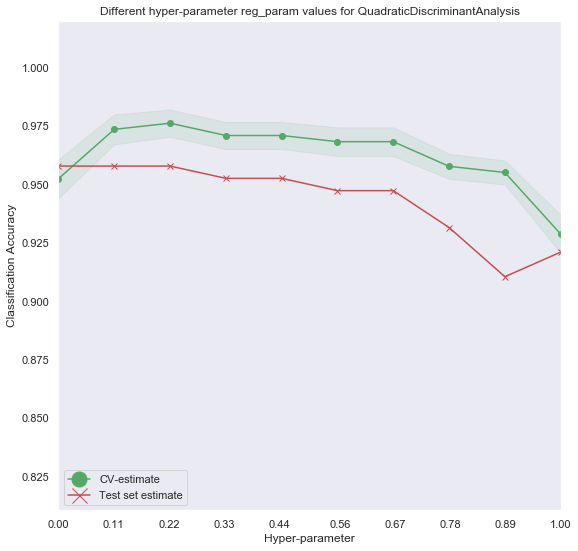

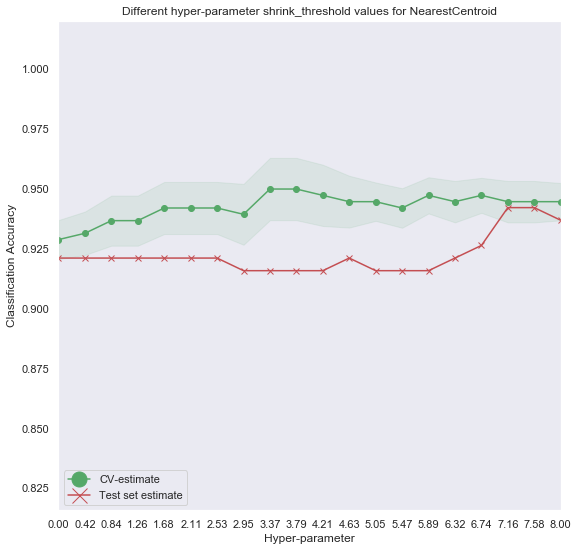

Parameters


,Parameters
QDA hyper-parameter reg_param,True
NSC Hyper-parameter shrink_threshold,True
Dimensionality Reduction,False
Retained variance,99
Number of iterations,1
Test set size,33.3333
Best hyperparameter select method,max_in_cv



Accuracy


,NBC,LDA,QDA,NSC
Train,0.947230,0.963061,0.976253,0.941953
Test,0.900000,0.973684,0.957895,0.915789
Overfit degree,0.049808,0.011020,0.018786,0.027746



TPR


,NBC,LDA,QDA,NSC
Train,0.974468,0.995745,0.995745,0.974468
Test,0.926230,1.000000,0.983607,0.950820
Overfit degree,0.049452,0.004269,0.012178,0.024243



TNR


,NBC,LDA,QDA,NSC
Train,0.902778,0.909722,0.944444,0.888889
Test,0.852941,0.926471,0.911765,0.852941
Overfit degree,0.055143,0.018390,0.034565,0.040396



Execution data


,Execution Data
Features reduction,0


In [225]:
gp_disable_plots = False
gp_verbose = False
gp_dim_red = False
gp_retained_variance = 99
gp_qda_hyper = True
gp_nsc_hyper = True
gp_iterations = 1
gp_show_progress = False
gp_best_hyper_method = "max_in_cv"
ge_features_reduction = 0

learn_dataset(data_file = './data/wdbc.csv', header = None, random_state=0, 
              label_pos=1, label_value="M", features_ini = 2, features_fin = None,
              best_param_value_method = gp_best_hyper_method,
              with_dim_red = gp_dim_red, retained_variance = gp_retained_variance)

## Prostate cancer

In [224]:
# Prostate Cancer
gp_disable_plots = True
gp_verbose = False
gp_dim_red = False
gp_retained_variance = 99
gp_qda_hyper = True
gp_nsc_hyper = True
gp_iterations = 20
gp_best_hyper_method = "max_in_cv"
ge_features_reduction = 0
learn_dataset(data_file = './data/prostate.csv', header = 0, random_state = 1, 
              label_pos = -1, label_value = 1, features_ini = 0, features_fin = -1,
              best_param_value_method = gp_best_hyper_method,
              with_dim_red = gp_dim_red, retained_variance = gp_retained_variance)

gp_best_hyper_method = "max_in_cv"
gp_dim_red = True
gp_retained_variance = 99
ge_features_reduction = 0
learn_dataset(data_file = './data/prostate.csv', header = 0, random_state = 1, 
              label_pos = -1, label_value = 1, features_ini = 0, features_fin = -1,
              best_param_value_method = gp_best_hyper_method,
              with_dim_red = gp_dim_red, retained_variance = gp_retained_variance)

gp_best_hyper_method = "max_in_cv"
gp_dim_red = True
gp_retained_variance = 80
ge_features_reduction = 0
learn_dataset(data_file = './data/prostate.csv', header = 0, random_state = 1, 
              label_pos = -1, label_value = 1, features_ini = 0, features_fin = -1,
              best_param_value_method = gp_best_hyper_method,
              with_dim_red = gp_dim_red, retained_variance = gp_retained_variance)

Parameters


,Parameters
QDA hyper-parameter reg_param,True
NSC Hyper-parameter shrink_threshold,True
Dimensionality Reduction,False
Retained variance,99
Number of iterations,20
Test set size,33.3333
Best hyperparameter select method,max_in_cv



Accuracy


,NBC,LDA,QDA,NSC
Train,0.719118,0.861029,0.257353,0.919853
Test,0.642647,0.845588,0.635294,0.883824
Overfit degree,0.106192,0.017913,1.462887,0.039126



TPR


,NBC,LDA,QDA,NSC
Train,0.757319,0.886196,0.270844,0.956133
Test,0.622456,0.900976,0.651747,0.930667
Overfit degree,0.177845,0.016659,1.401186,0.026607



TNR


,NBC,LDA,QDA,NSC
Train,0.681027,0.833810,0.244501,0.882555
Test,0.660856,0.803124,0.595462,0.840355
Overfit degree,0.029576,0.036759,1.429567,0.047762



Execution data


,Execution Data
Features reduction,0



Parameters


,Parameters
QDA hyper-parameter reg_param,True
NSC Hyper-parameter shrink_threshold,True
Dimensionality Reduction,True
Retained variance,99
Number of iterations,20
Test set size,33.3333
Best hyperparameter select method,max_in_cv



Accuracy


,NBC,LDA,QDA,NSC
Train,0.923529,1.0000,0.895588,0.747059
Test,0.738235,0.9000,0.717647,0.705882
Overfit degree,0.200420,0.0999,0.198465,0.055044



TPR


,NBC,LDA,QDA,NSC
Train,0.931280,1.000000,0.916791,0.753448
Test,0.480687,0.933113,0.718588,0.684330
Overfit degree,0.483323,0.066820,0.215956,0.091614



TNR


,NBC,LDA,QDA,NSC
Train,0.915929,1.000000,0.880210,0.739944
Test,0.953393,0.871294,0.708369,0.722905
Overfit degree,0.040859,0.128578,0.195006,0.022996



Execution data


,Execution Data
Features reduction,63



Parameters


,Parameters
QDA hyper-parameter reg_param,True
NSC Hyper-parameter shrink_threshold,True
Dimensionality Reduction,True
Retained variance,80
Number of iterations,20
Test set size,33.3333
Best hyperparameter select method,max_in_cv



Accuracy


,NBC,LDA,QDA,NSC
Train,0.885294,0.958088,0.981618,0.738235
Test,0.783824,0.848529,0.857353,0.701471
Overfit degree,0.114489,0.114232,0.126463,0.049733



TPR


,NBC,LDA,QDA,NSC
Train,0.944675,0.985033,0.994434,0.742479
Test,0.937114,0.894231,0.858607,0.681252
Overfit degree,0.007996,0.092087,0.136449,0.082351



TNR


,NBC,LDA,QDA,NSC
Train,0.822114,0.929172,0.968597,0.733708
Test,0.658617,0.817581,0.863666,0.717746
Overfit degree,0.198633,0.119968,0.108222,0.021726



Execution data


,Execution Data
Features reduction,19


### Hyper-parameter guessing plots

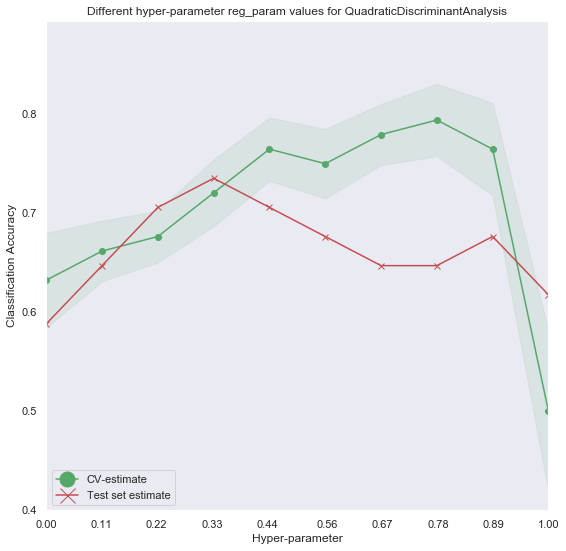

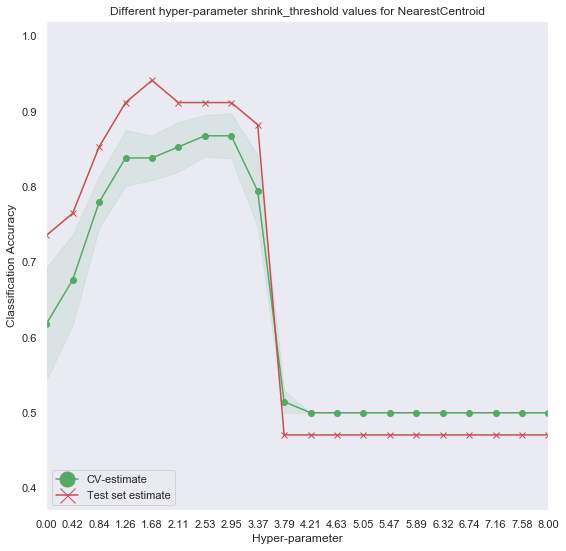

Parameters


,Parameters
QDA hyper-parameter reg_param,True
NSC Hyper-parameter shrink_threshold,True
Dimensionality Reduction,False
Retained variance,99
Number of iterations,1
Test set size,33.3333
Best hyperparameter select method,max_in_cv



Accuracy


,NBC,LDA,QDA,NSC
Train,0.823529,0.823529,0.000000,0.941176
Test,0.823529,0.852941,0.647059,0.911765
Overfit degree,0.000000,0.035671,647.058824,0.031217



TPR


,NBC,LDA,QDA,NSC
Train,0.911765,0.794118,0.00,0.941176
Test,0.812500,0.937500,0.75,0.937500
Overfit degree,0.108752,0.180328,750.00,0.003902



TNR


,NBC,LDA,QDA,NSC
Train,0.735294,0.852941,0.000000,0.941176
Test,0.833333,0.777778,0.555556,0.888889
Overfit degree,0.133152,0.088019,555.555556,0.055497



Execution data


,Execution Data
Features reduction,0


In [226]:
gp_disable_plots = False
gp_verbose = False
gp_dim_red = False
gp_retained_variance = 99
gp_qda_hyper = True
gp_nsc_hyper = True
gp_iterations = 1
gp_best_hyper_method = "max_in_cv"
ge_features_reduction = 0
learn_dataset(data_file = './data/prostate.csv', header = 0, random_state = 1, 
              label_pos = -1, label_value = 1, features_ini = 0, features_fin = -1,
              best_param_value_method = gp_best_hyper_method,
              with_dim_red = gp_dim_red, retained_variance = gp_retained_variance)

## Conclusions

We observe that **QDA** performs very poorly in the prostate dataset, given the high dimensionality of this dataset, which do not ease the accurate computation of the covariance matrices. Perhaps if we perform previously a dimensionality reduction by PCA, we'll improve this result.

**NSC** performs in this case much better due to the reduced number of parameters and the feature selection properties of this classifier and more consistently between both cases (prostate and breast).

# Outputs

In [227]:
%%bash
jupyter nbconvert --to=latex --template=~/report.tplx classification_systems.ipynb 1> /dev/null
pdflatex -shell-escape classification_systems 1> /dev/null
jupyter nbconvert --to html_with_toclenvs classification_systems.ipynb 1> /dev/null

[NbConvertApp] Converting notebook classification_systems.ipynb to latex
[NbConvertApp] Support files will be in classification_systems_files/
[NbConvertApp] Making directory classification_systems_files
[NbConvertApp] Making directory classification_systems_files
[NbConvertApp] Making directory classification_systems_files
[NbConvertApp] Making directory classification_systems_files
[NbConvertApp] Writing 65698 bytes to classification_systems.tex
[NbConvertApp] Converting notebook classification_systems.ipynb to html_with_toclenvs
[NbConvertApp] Writing 641050 bytes to classification_systems.html
